In [1]:
from pathlib import Path
from astropy import units as u
from astropy.stats import sigma_clipped_stats
from astropy.table import Table
from astropy.time import Time
from astropy.timeseries import aggregate_downsample
from astropy.timeseries import TimeSeries
from astropy.timeseries import BinnedTimeSeries

import re
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def boundify(a, sigma=2.0):
    mean = a.mean()
    dev = np.std(a)
    
    return (mean - (sigma * dev)).value, (mean + (sigma * dev)).value

def filter_nan(ts, filter_column):
    nans = np.isnan(ts[filter_column].data)
    return ts[~nans]

def filter_inf(ts, filter_column):
    infs = np.isinf(ts[filter_column].data)
    return ts[~infs]

def check_filter(labels):
    values = []
    
    for label in labels:
        if re.match(r'.*_B[0-9]+_.*', str(label)):
            values.append('Blue')
        elif re.match(r'.*_V[0-9]+_.*', str(label)):
            values.append('Green')
        elif re.match(r'.*_R[0-9]+_.*', str(label)):
            values.append('Red')
        else:
            values.append('Unknown')
    
    return values

plot_value = 'Source_AMag_T1'
plot_sigma = 'Source_AMag_Err_T1'

In [3]:
# constants
object_name = 'CRTS J092751.8-040759'
working_directory = Path('/data/PIRATE/FITS/') / object_name
csv_data = working_directory / 'measurements.csv'

# TODO: automatically infer this from the FITS data
period = 8.644721539544374 * u.hour

plt.style.use('guide.mplstyle')

In [4]:
t = Table.read(csv_data, format='ascii.csv', delimiter=',', fast_reader=False)
# curate columns
t['JD_UTC'].unit = u.day
t['time'] = Time(t['JD_UTC'], format='jd')
t['filter'] = check_filter(t['Label'])

for row in t:
    check_filter(row)

# remove unwanted data
t.keep_columns(['time','rel_flux_T1', 'rel_flux_err_T1', 'Source_AMag_T1', 'Source_AMag_Err_T1', 'Source_SNR_T1', 'filter'])
t['rel_flux_T1'].unit = 'electron/s'
t['rel_flux_err_T1'].unit = 'electron/s'
t['Source_AMag_T1'].unit = 'mag'
t['Source_AMag_Err_T1'].unit = 'mag'

In [5]:
ts = TimeSeries(t)
t

rel_flux_T1,rel_flux_err_T1,Source_AMag_T1,Source_AMag_Err_T1,Source_SNR_T1,time,filter
electron / s,electron / s,mag,mag,,,
float64,float64,float64,float64,float64,object,str5
0.025111,0.000142,12.898522,0.006133,178.31251,2458542.398672,Blue
0.025535,0.000122,12.880338,0.005174,211.320513,2458542.400183,Green
0.018194,0.000127,13.24838,0.007556,143.990504,2458542.401377,Red
0.026068,0.000145,12.857915,0.006026,181.582798,2458542.402587,Blue
0.027049,0.00013,12.817798,0.005194,210.635769,2458542.404122,Green
0.018878,0.000132,13.208293,0.007563,143.896671,2458542.405296,Red
0.026908,0.000149,12.823475,0.005996,182.574516,2458542.406519,Blue
0.025773,0.000122,12.870265,0.005126,213.330919,2458542.408051,Green


In [78]:
ts_folded = ts.fold(
    period=period,
    normalize_phase=False,
    wrap_phase=period,
    epoch_phase=0.65 * period)
ts_folded = filter_nan(ts_folded, plot_value)
ts_folded = filter_inf(ts_folded, plot_value)
#ts_folded.sort('time')

period.to(u.day)

<Quantity 0.36019673 d>

ValueError: setting an array element with a sequence.

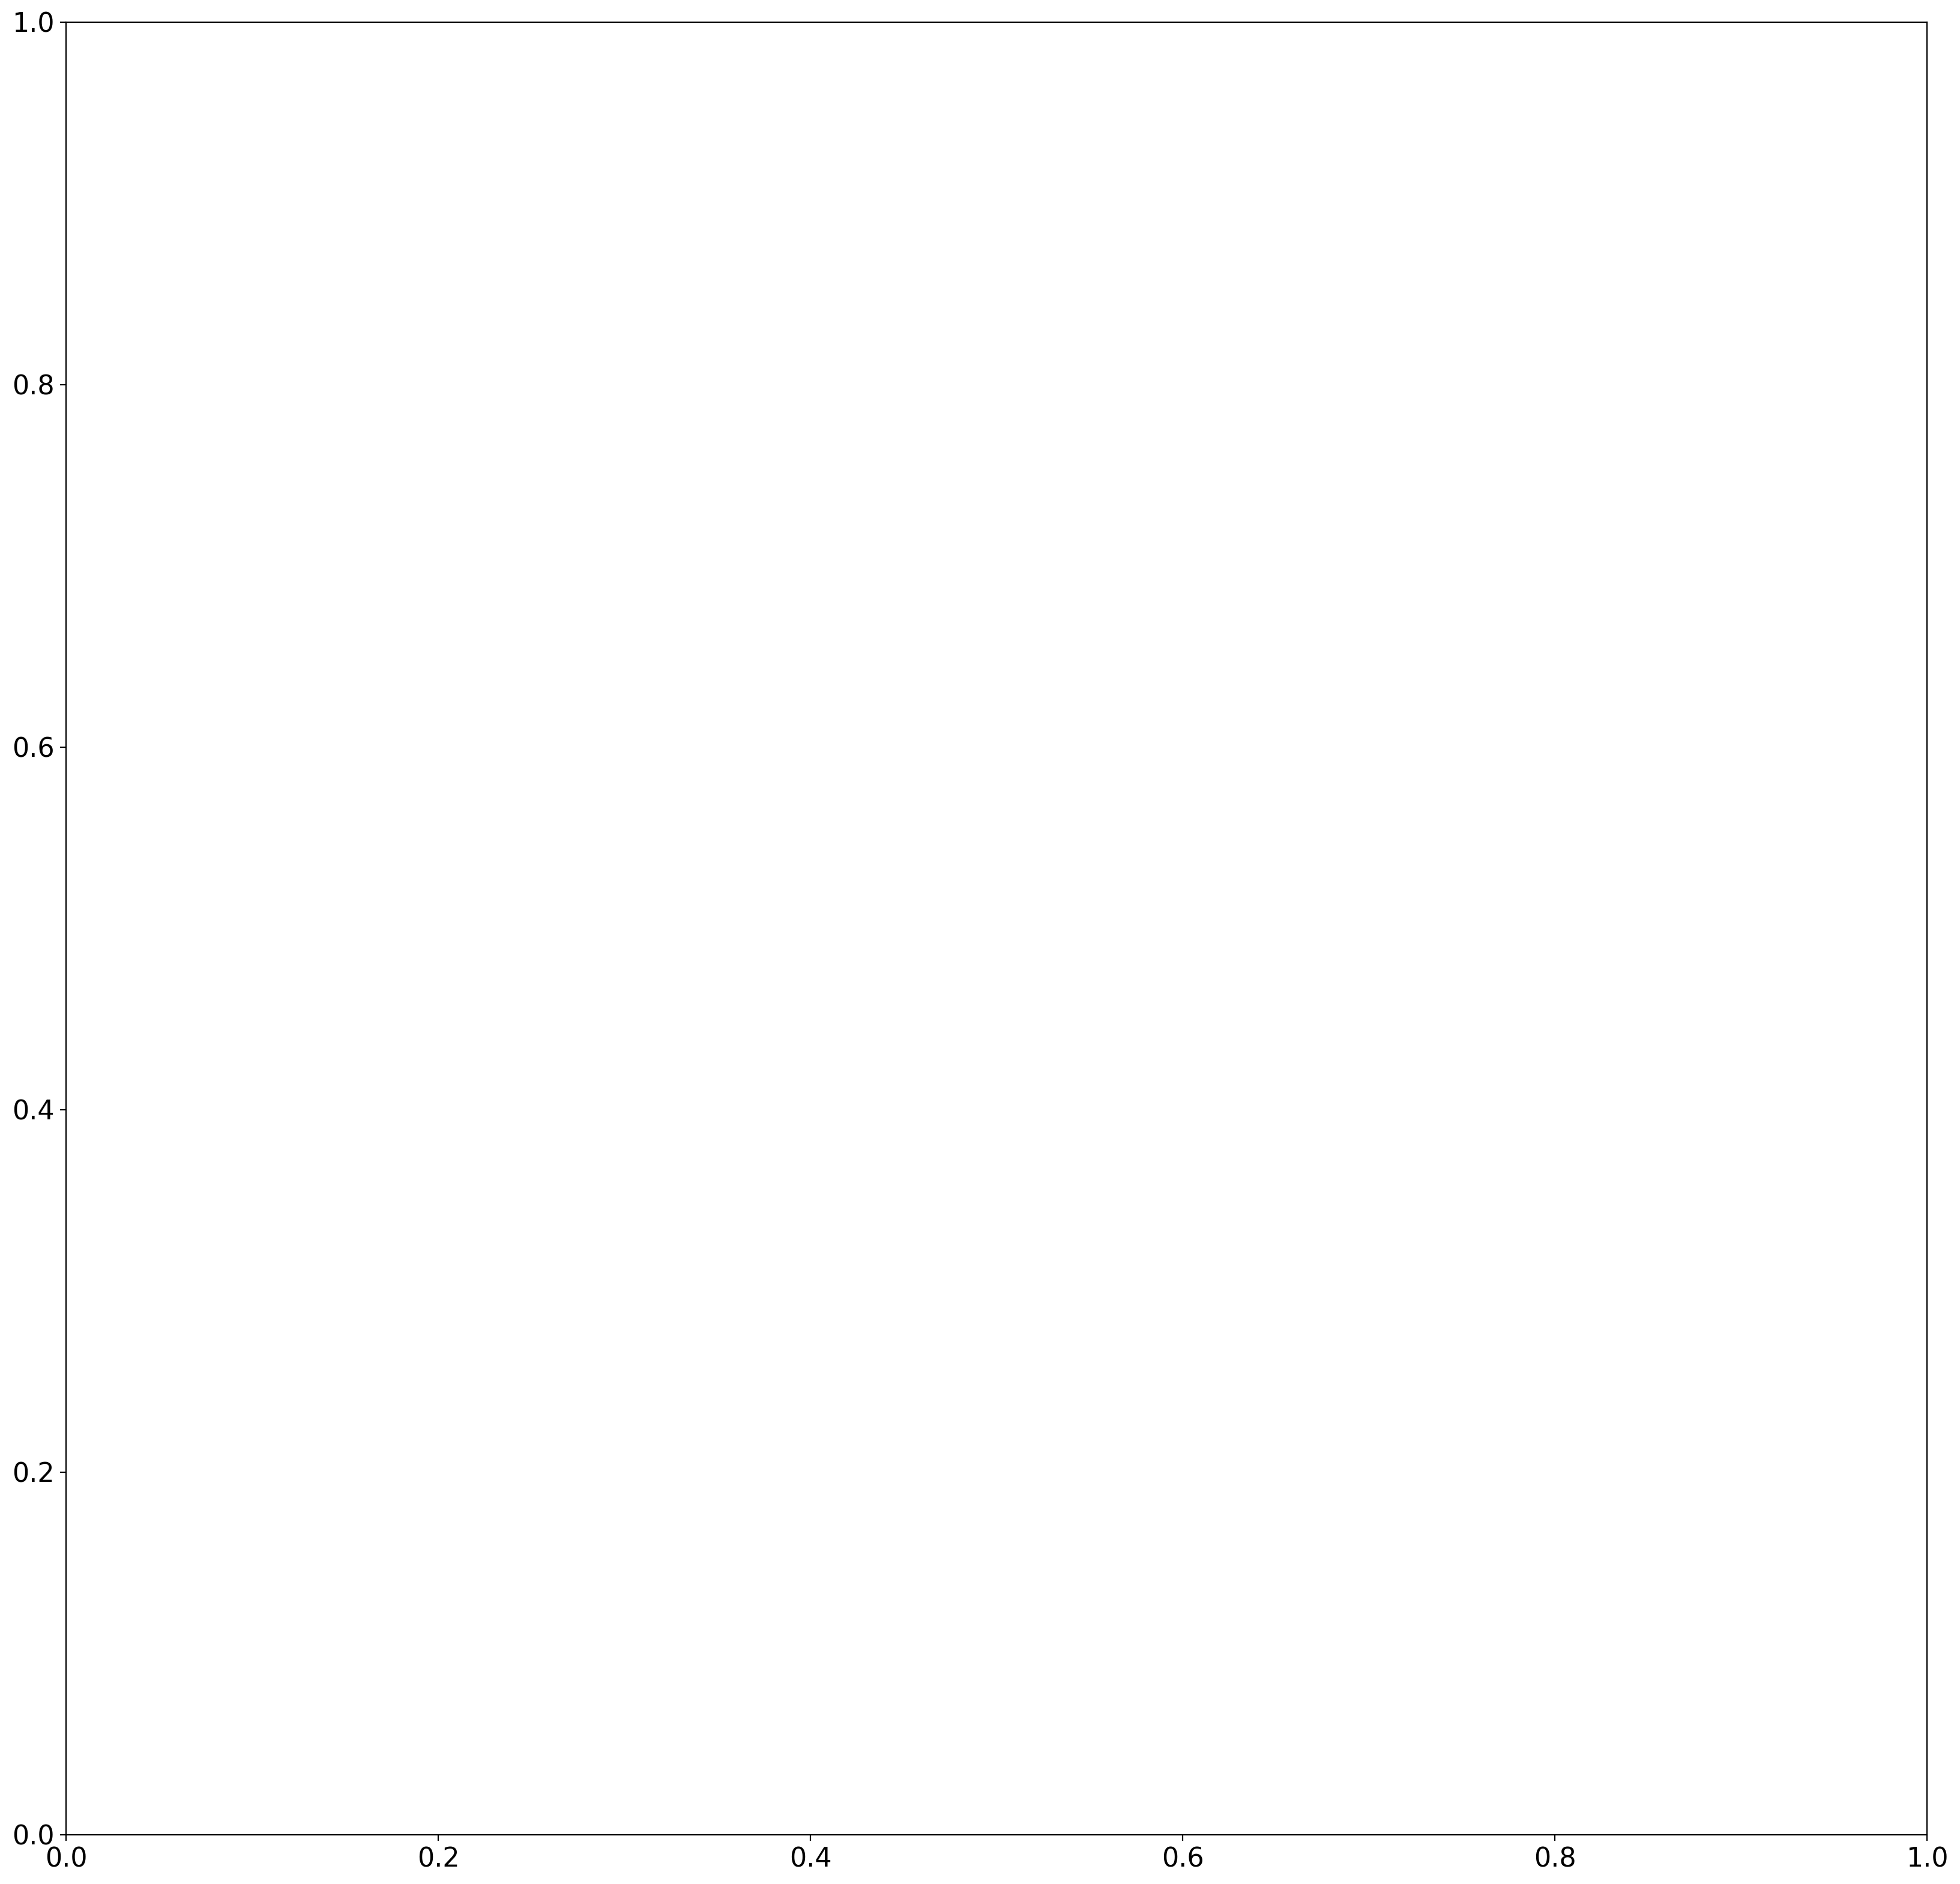

In [79]:
y_min, y_max = boundify(ts_folded[plot_value])
#y_min = 0.00
#y_max = 0.02

kwargs = { 'markersize': 3, 'marker': '^', 'linestyle': '' }

plt.figure(figsize=(20,20))
plt.plot(ts_folded.time, ts_folded[plot_value], 'k.', **kwargs)
plt.plot(ts_folded.time - 1.0, ts_folded[plot_value], 'k.', **kwargs)
plt.ylim(bottom=y_min, top=y_max)
plt.xlabel('Phase')
plt.ylabel('SAP Flux (e-/s)')

In [80]:
# seperate the colour channels
ts_red = filter_inf(ts_folded[ts_folded['filter'] == 'Red'], plot_value)
ts_green = filter_inf(ts_folded[ts_folded['filter'] == 'Green'], plot_value)
ts_blue = filter_inf(ts_folded[ts_folded['filter'] == 'Blue'], plot_value)

ts_red = filter_nan(ts_red, plot_value)
ts_green = filter_nan(ts_green, plot_value)
ts_blue = filter_nan(ts_blue, plot_value)

#ts_red.keep_columns(['time', 'Source_AMag_T1', 'Source_AMag_Err_T1'])
#ts_green.keep_columns(['time', 'Source_AMag_T1', 'Source_AMag_Err_T1'])
#ts_blue.keep_columns(['time', 'Source_AMag_T1', 'Source_AMag_Err_T1'])


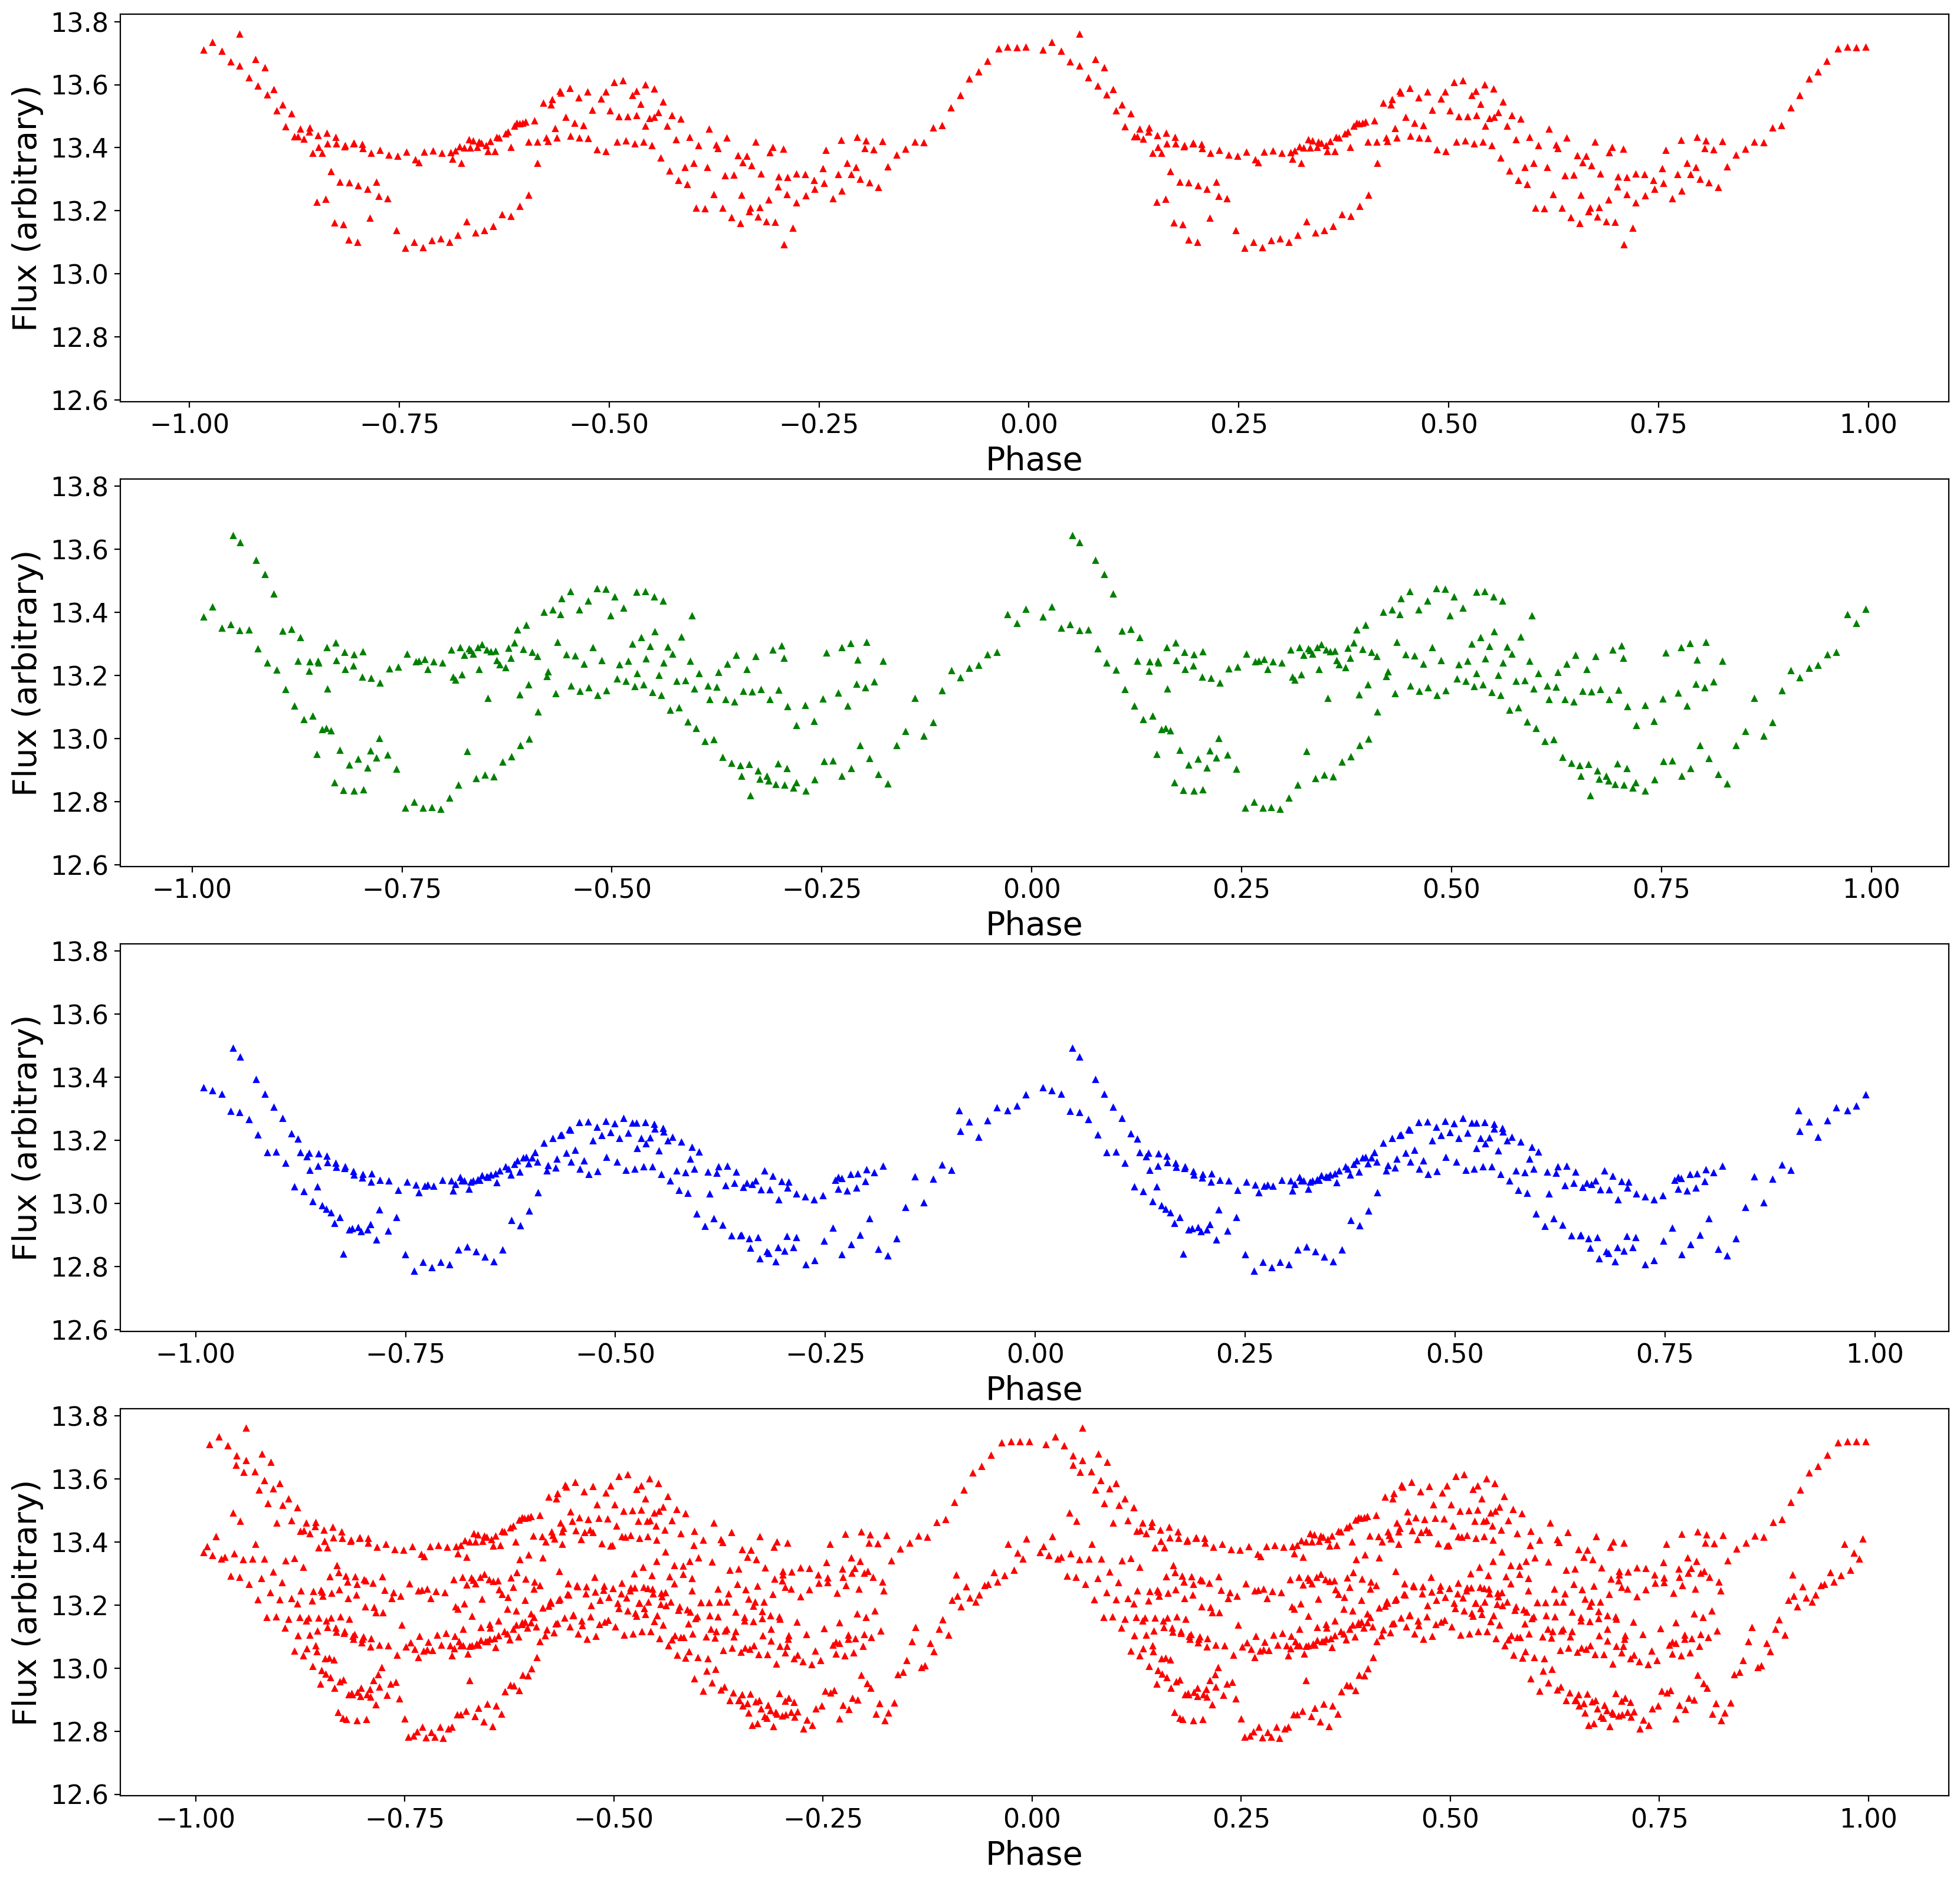

In [81]:
y_min, y_max = boundify(ts_folded[plot_value], sigma=3)
#y_min = 12.5
#y_max = 14.0

fig = plt.figure(figsize=(20,20))

xlabel = 'Phase'
ylabel = 'Flux (arbitrary)'
kwargs = { 'markersize': 3, 'marker': '^', 'linestyle': '' }

ax1 = fig.add_subplot(411)
#ax1.plot(ts_red.time, ts_red[plot_value].value, 'r.', **kwargs)
#ax1.plot(ts_red.time - 1.0, ts_red[plot_value].value, 'r.', **kwargs)
ax1.plot((ts_red.time.jd / period.to(u.day)).value, ts_red[plot_value].value, 'r.', **kwargs)
ax1.plot((ts_red.time.jd / period.to(u.day)).value - 1.0, ts_red[plot_value].value, 'r.', **kwargs)
#ax1.plot((ts_red_mean.time_bin_start.jd / period.to(u.day)).value, ts_red_mean[plot_value].value, 'k.', **kwargs)
#ax1.plot((ts_red_mean.time_bin_start.jd / period.to(u.day)).value - 1.0, ts_red_mean[plot_value].value, 'k.', **kwargs)
ax1.set_ylim(y_min, y_max)
ax1.set_xlabel(xlabel)
ax1.set_ylabel(ylabel)

ax2 = fig.add_subplot(412)
#ax2.plot(ts_green.time, ts_green[plot_value].value, 'g.', **kwargs)
#ax2.plot(ts_green.time - 1.0, ts_green[plot_value].value, 'g.', **kwargs)
ax2.plot((ts_green.time.jd / period.to(u.day)).value, ts_green[plot_value].value, 'g.', **kwargs)
ax2.plot((ts_green.time.jd / period.to(u.day)).value - 1.0, ts_green[plot_value].value, 'g.', **kwargs)
#ax2.plot((ts_green_mean.time_bin_start.jd / period.to(u.day)).value, ts_green_mean[plot_value].value, 'k.', **kwargs)
#ax2.plot((ts_green_mean.time_bin_start.jd / period.to(u.day)).value - 1.0, ts_green_mean[plot_value].value, 'k.', **kwargs)
ax2.set_ylim(y_min, y_max)
ax2.set_xlabel(xlabel)
ax2.set_ylabel(ylabel)

ax3 = fig.add_subplot(413)
#ax3.plot(ts_blue.time, ts_blue[plot_value].value, 'b.', **kwargs)
#ax3.plot(ts_blue.time - 1.0, ts_blue[plot_value].value, 'b.', **kwargs)
ax3.plot((ts_blue.time.jd / period.to(u.day)).value, ts_blue[plot_value].value, 'b.', **kwargs)
ax3.plot((ts_blue.time.jd / period.to(u.day)).value - 1.0, ts_blue[plot_value].value, 'b.', **kwargs)
#ax3.plot((ts_blue_mean.time_bin_start.jd / period.to(u.day)).value, ts_blue_mean[plot_value].value, 'k.', **kwargs)
#ax3.plot((ts_blue_mean.time_bin_start.jd / period.to(u.day)).value - 1.0, ts_blue_mean[plot_value].value, 'k.', **kwargs)
ax3.set_ylim(y_min, y_max)
ax3.set_xlabel(xlabel)
ax3.set_ylabel(ylabel)

ax4 = fig.add_subplot(414)
#ax4.plot(ts_red.time, ts_red[plot_value].value, 'r.', **kwargs)
#ax4.plot(ts_red.time - 1.0, ts_red[plot_value].value, 'r.', **kwargs)
#ax4.plot(ts_green.time, ts_green[plot_value].value, 'g.', **kwargs)
#ax4.plot(ts_green.time - 1.0, ts_green[plot_value].value, 'g.', **kwargs)
#ax4.plot(ts_blue.time, ts_blue[plot_value].value, 'b.', **kwargs)
#ax4.plot(ts_blue.time - 1.0, ts_blue[plot_value].value, 'b.', **kwargs)
ax4.plot((ts_red.time.jd / period.to(u.day)).value, ts_red[plot_value].value, 'r.', **kwargs)
ax4.plot((ts_red.time.jd / period.to(u.day)).value - 1.0, ts_red[plot_value].value, 'r.', **kwargs)
ax4.plot((ts_green.time.jd / period.to(u.day)).value, ts_green[plot_value].value, 'r.', **kwargs)
ax4.plot((ts_green.time.jd / period.to(u.day)).value - 1.0, ts_green[plot_value].value, 'r.', **kwargs)
ax4.plot((ts_blue.time.jd / period.to(u.day)).value, ts_blue[plot_value].value, 'r.', **kwargs)
ax4.plot((ts_blue.time.jd / period.to(u.day)).value - 1.0, ts_blue[plot_value].value, 'r.', **kwargs)
ax4.set_ylim(y_min, y_max)
ax4.set_xlabel(xlabel)
ax4.set_ylabel(ylabel)


fig.show()

In [8]:
fig.savefig(csv_data.with_suffix('.png'), format='png')

NameError: name 'fig' is not defined

In [82]:
r_mag = ts_red[plot_value].min()
v_mag = ts_green[plot_value].min()
b_mag = ts_blue[plot_value].min()

print('R = ', r_mag)
print('V = ', v_mag)
print('B = ', b_mag)
print('B-V = ', b_mag - v_mag)
print('V-R = ', v_mag - r_mag)

print('Teff = ', np.power(10, ((b_mag.value - v_mag.value - 14.551) / -3.684)))
print('Teff = ', 4600.0 * ((1.0/((0.92 * (b_mag.value - v_mag.value)) + 1.7)) + (1.0/((0.92 * (b_mag.value - v_mag.value)) + 0.62))))

R =  13.080051 mag
V =  12.776318 mag
B =  12.785202 mag
B-V =  0.008884000000000114 mag
V-R =  -0.30373299999999936 mag
Teff =  8858.72735282133
Teff =  10015.755452928832


In [83]:
export_columns=['time', 'Source_AMag_T1', 'Source_AMag_Err_T1']

ts_red[export_columns].write(working_directory / 'red.phoebe', format='ascii.csv', delimiter=' ')
ts_green[export_columns].write(working_directory / 'green.phoebe', format='ascii.csv', delimiter=' ')
ts_blue[export_columns].write(working_directory / 'blue.phoebe', format='ascii.csv', delimiter=' ')